In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


In [29]:
# Read the data from a CSV file and select relevant columns
df_queries = pd.read_csv('antique_query_test.csv')
df_queries = df_queries[['query_id','text']]

df_docs = pd.read_csv('antique_sample_404k.csv')
df_docs = df_docs[['doc_id','text']]

df_qrel = pd.read_csv('antique_qurel_test.csv')
df_qrel = df_qrel[['query_id','doc_id','relevance']]

In [30]:
# Define a function to map relevance values to binary labels
def map_values(value):
    if value in [3, 4]:
        return 1
    else:
        return 0

In [31]:
# Apply the mapping function to create binary labels and add to the relevance data
df_qrel['label'] = df_qrel['relevance'].apply(map_values)

# Drop duplicate entries based on query_id and doc_id in the relevance data
df_qrel1 = df_qrel.drop_duplicates(subset=['query_id','doc_id'])
df_qrel1

,query_id,doc_id,relevance,label
0,1964316,1964316_5,4,1
1,1964316,1674088_11,1,0
2,1964316,1218838_13,2,0
3,1964316,1519022_15,2,0
4,1964316,3059341_5,2,0
...,...,...,...,...
6584,1262692,247023_6,3,1
6585,1262692,1499030_5,3,1
6586,1262692,2916758_0,3,1
6587,1262692,1105845_15,3,1


In [32]:
# Merge the query data and relevance data based on query_id
merged_df = df_queries.merge(df_qrel1, on='query_id', how='left')

# Drop duplicate entries based on query_id and doc_id in the merged data
merged_df = merged_df.drop_duplicates(subset=['query_id','doc_id'])
merged_df

,query_id,text,doc_id,relevance,label
0,3990512,how can we get concentration onsomething?,3990512_1,4,1
1,3990512,how can we get concentration onsomething?,2036065_1,2,0
2,3990512,how can we get concentration onsomething?,3265991_12,2,0
3,3990512,how can we get concentration onsomething?,3149758_0,1,0
4,3990512,how can we get concentration onsomething?,3990512_0,3,1
...,...,...,...,...,...
6584,1971899,what is masturbat***?,1971899_6,2,0
6585,1971899,what is masturbat***?,1971899_7,2,0
6586,1971899,what is masturbat***?,1971899_1,4,1
6587,1971899,what is masturbat***?,1971899_2,1,0


## Basic EDA

In [33]:
# Create a DataFrame for exploratory data analysis (EDA) with relevant columns
eda_df =  merged_df[['query_id','doc_id','label']]

# Print basic information about the EDA DataFrame
print("Basic Information:")
print(eda_df.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   query_id  6589 non-null   int64 
 1   doc_id    6589 non-null   object
 2   label     6589 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 154.6+ KB
None


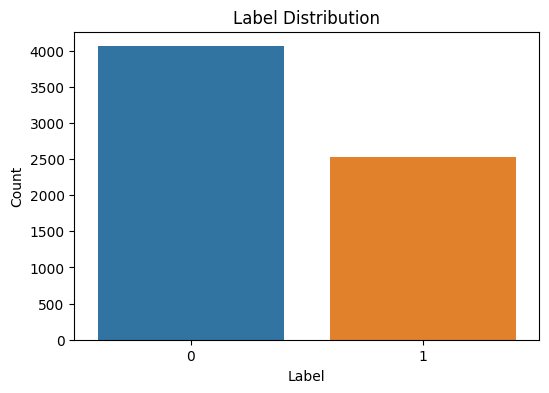

In [34]:
# Count the occurrences of each label and visualize the label distribution
label_counts = eda_df['label'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='label')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [35]:
# Calculate and display the number of unique query_ids and doc_ids
unique_query_ids = eda_df['query_id'].nunique()
unique_doc_ids = eda_df['doc_id'].nunique()
print(f"\nNumber of unique query_ids: {unique_query_ids}")
print(f"Number of unique doc_ids: {unique_doc_ids}")


Number of unique query_ids: 200
Number of unique doc_ids: 6486


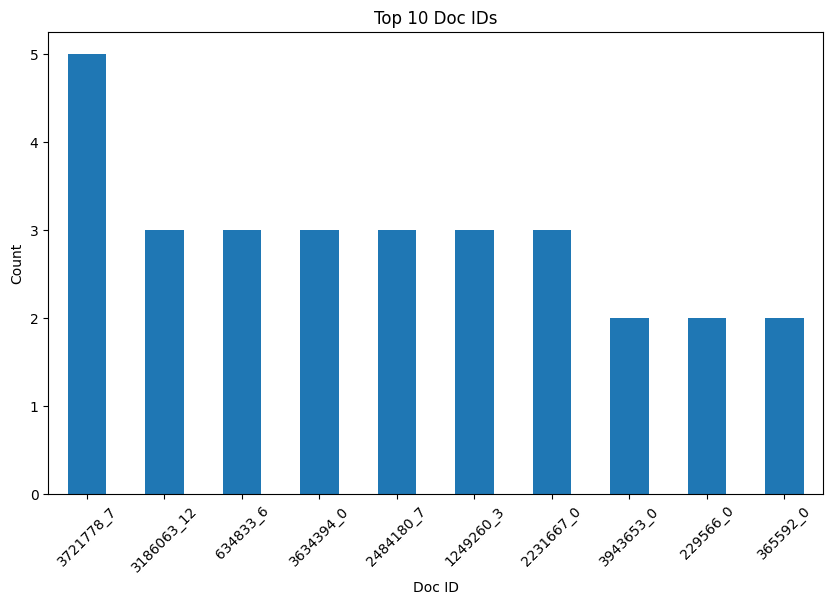

In [36]:
# Visualize the top 10 most common doc_ids
top_doc_ids = eda_df['doc_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_doc_ids.plot(kind='bar')
plt.title("Top 10 Doc IDs")
plt.xlabel("Doc ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [37]:
# Group data by query_id and calculate the count of documents per query
doc_count_per_query = eda_df.groupby('query_id')['doc_id'].count().reset_index(name='doc_count')

# Sort the results by document count in descending order
doc_count_per_query.sort_values(by='doc_count', ascending=[False])

,query_id,doc_count
173,4018891,84
194,4406669,68
191,4372730,64
79,1866981,64
41,922849,60
...,...,...
197,4467100,12
192,4377861,9
146,3382736,9
11,224109,4


In [38]:
# Group data by query_id and calculate various statistics
doc_count_per_query = eda_df.groupby('query_id').agg(doc_count=('doc_id', 'count'),
                                                      label_1_count=('label', 'sum'),
                                                      label_0_count=('label', lambda x: (x == 0).sum()),
                                                      ).reset_index()

# Sort the results by document count in descending order
sorted_doc_count_per_query = doc_count_per_query.sort_values(by='doc_count', ascending=False)

sorted_doc_count_per_query

,query_id,doc_count,label_1_count,label_0_count
173,4018891,84,35,49
194,4406669,68,41,27
191,4372730,64,28,36
79,1866981,64,19,45
41,922849,60,25,35
...,...,...,...,...
197,4467100,12,1,11
192,4377861,9,4,5
146,3382736,9,4,5
11,224109,4,1,3


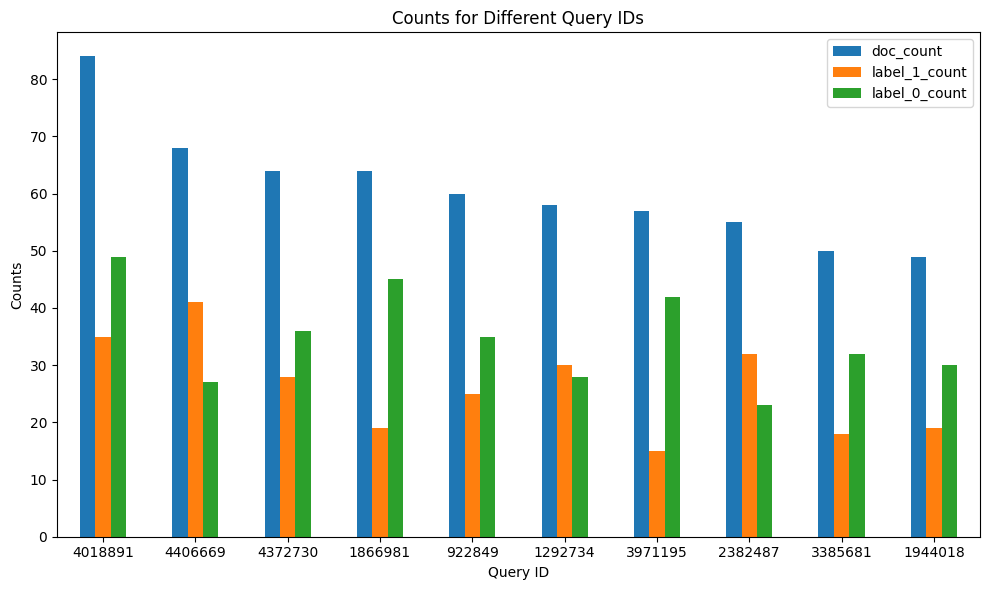

In [39]:
# Select the top 10 query_ids by document count
sorted_doc_count_per_query = sorted_doc_count_per_query.head(10)
sorted_doc_count_per_query.set_index('query_id', inplace=True)

# Visualize the document count and label statistics for the top 10 query_ids
ax = sorted_doc_count_per_query.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Counts')
ax.set_xlabel('Query ID')
ax.set_title('Counts for Different Query IDs')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()

In [63]:
# Merge the previously merged DataFrame with the document data based on doc_id
merged_df_docs = merged_df.merge(df_docs, on='doc_id', how='left')

In [64]:
merged_df_docs

,query_id,text_x,doc_id,relevance,label,text_y
0,3990512,how can we get concentration onsomething?,3990512_1,4,1,"For one thing, focus on what you want to achie..."
1,3990512,how can we get concentration onsomething?,2036065_1,2,0,just by concentration
2,3990512,how can we get concentration onsomething?,3265991_12,2,0,concentration
3,3990512,how can we get concentration onsomething?,3149758_0,1,0,Diffusion is when solutes go from a higher con...
4,3990512,how can we get concentration onsomething?,3990512_0,3,1,Try blocking the distractions as much as possi...
...,...,...,...,...,...,...
6584,1971899,what is masturbat***?,1971899_6,2,0,what is masturbat***?
6585,1971899,what is masturbat***?,1971899_7,2,0,u dont no??
6586,1971899,what is masturbat***?,1971899_1,4,1,It's when you manually self-stimulate your gen...
6587,1971899,what is masturbat***?,1971899_2,1,0,go ask yo mama


In [65]:
stop_words_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
    'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
    'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by',
    'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
    'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
    'will', 'just', 'don', 'should', 'now'
]

## Analysis on Docs

       text_y_word_count  text_y_char_count
count        6589.000000        6589.000000
mean           45.589164         247.380483
std            56.968753         323.042317
min             1.000000           3.000000
25%            15.000000          78.000000
50%            31.000000         164.000000
75%            56.000000         302.000000
max           719.000000        3898.000000

Top 10 most common words:
[('the', 13013), ('to', 8052), ('and', 7304), ('a', 7062), ('of', 6232), ('is', 5524), ('you', 4695), ('in', 4138), ('it', 3837), ('that', 3525)]

Top 10 most common non-stopwords:
[('people', 1144), ('dont', 1057), ('like', 999), ('get', 981), ('would', 732), ('one', 723), ('know', 714), ('think', 699), ('make', 559), ('go', 536)]



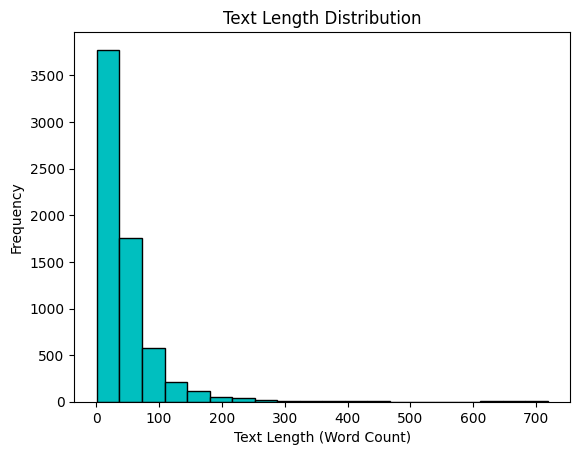

TF-IDF Matrix shape: (6589, 22012)


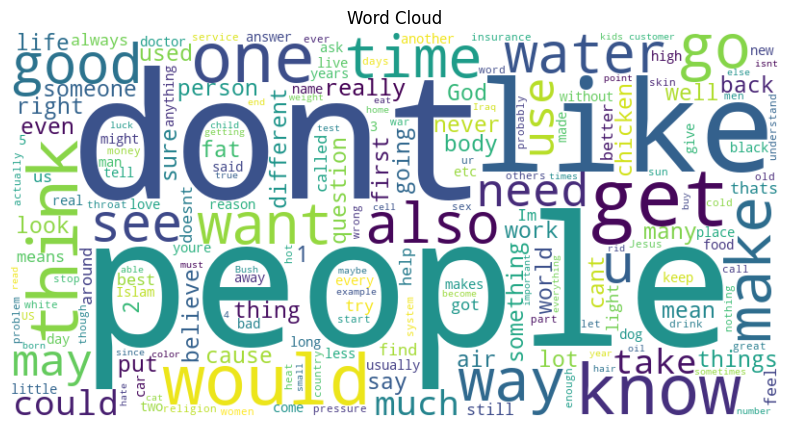

In [66]:
# Manually set stopwords (you can customize this list)
custom_stopwords = set(stop_words_list)

# Function to preprocess text
def preprocess_text(text):
    # Remove punctuation and symbols using regular expressions
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

# Apply preprocessing to text
merged_df_docs['cleaned_text_y'] = merged_df_docs['text_y'].apply(preprocess_text)

# Word and character counts
merged_df_docs['text_y_word_count'] = merged_df_docs['cleaned_text_y'].apply(lambda x: len(word_tokenize(x)))
merged_df_docs['text_y_char_count'] = merged_df_docs['cleaned_text_y'].apply(lambda x: len(x))
print(merged_df_docs[['text_y_word_count', 'text_y_char_count']].describe())
print()

# Top words and phrases
words = word_tokenize(' '.join(merged_df_docs['cleaned_text_y']))
fdist = FreqDist(words)
print("Top 10 most common words:")
print(fdist.most_common(10))
print()

# Stopwords analysis
filtered_words = [[word for word in word_tokenize(text) if word.lower() not in custom_stopwords] for text in merged_df_docs['cleaned_text_y']]
fdist_filtered = FreqDist([word for sublist in filtered_words for word in sublist])
print("Top 10 most common non-stopwords:")
print(fdist_filtered.most_common(10))
print()

# Text length distribution
plt.hist(merged_df_docs['text_y_word_count'], bins=20, color='c', edgecolor='black')
plt.xlabel('Text Length (Word Count)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

# TF-IDF Vectorization (number_of_documents, number_of_unique_words)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(text) for text in filtered_words])
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist_filtered)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


In [67]:
merged_df_docs.head()

,query_id,text_x,doc_id,relevance,label,text_y,cleaned_text_y,text_y_word_count,text_y_char_count
0,3990512,how can we get concentration onsomething?,3990512_1,4,1,"For one thing, focus on what you want to achie...",For one thing focus on what you want to achiev...,51,296
1,3990512,how can we get concentration onsomething?,2036065_1,2,0,just by concentration,just by concentration,3,21
2,3990512,how can we get concentration onsomething?,3265991_12,2,0,concentration,concentration,1,13
3,3990512,how can we get concentration onsomething?,3149758_0,1,0,Diffusion is when solutes go from a higher con...,Diffusion is when solutes go from a higher con...,37,235
4,3990512,how can we get concentration onsomething?,3990512_0,3,1,Try blocking the distractions as much as possi...,Try blocking the distractions as much as possible,8,49


## Analysis on Queries

       text_word_count  text_char_count
count       200.000000       200.000000
mean          9.240000        46.900000
std           4.066334        21.214862
min           3.000000        13.000000
25%           6.000000        31.000000
50%           8.000000        42.500000
75%          11.250000        59.000000
max          20.000000       107.000000

Top 10 most common words:
[('the', 68), ('do', 60), ('Why', 52), ('is', 52), ('a', 47), ('to', 43), ('how', 36), ('How', 36), ('of', 33), ('what', 33)]

Top 10 most common non-stopwords:
[('people', 17), ('get', 16), ('mean', 9), ('make', 8), ('like', 7), ('rid', 6), ('dont', 6), ('know', 5), ('without', 5), ('black', 5)]



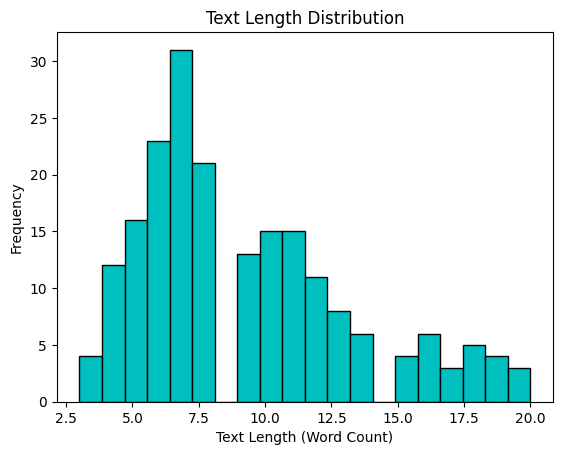

TF-IDF Matrix shape: (200, 684)


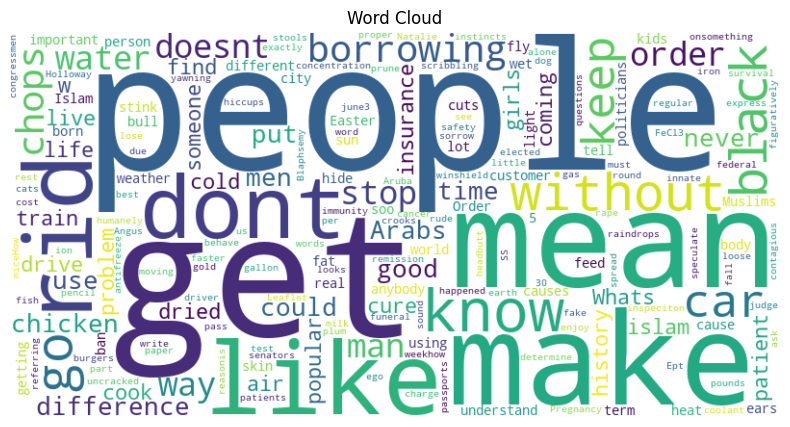

In [71]:
# Manually set stopwords (you can customize this list)
custom_stopwords = set(stop_words_list)

# Apply preprocessing to text
df_queries['cleaned_text'] = df_queries['text'].apply(preprocess_text)

# Word and character counts
df_queries['text_word_count'] = df_queries['cleaned_text'].apply(lambda x: len(word_tokenize(x)))
df_queries['text_char_count'] = df_queries['cleaned_text'].apply(lambda x: len(x))
print(df_queries[['text_word_count', 'text_char_count']].describe())
print()

# Top words and phrases
words = word_tokenize(' '.join(df_queries['cleaned_text']))
fdist = FreqDist(words)
print("Top 10 most common words:")
print(fdist.most_common(10))
print()

# Stopwords analysis
filtered_words = [[word for word in word_tokenize(text) if word.lower() not in custom_stopwords] for text in df_queries['cleaned_text']]
fdist_filtered = FreqDist([word for sublist in filtered_words for word in sublist])
print("Top 10 most common non-stopwords:")
print(fdist_filtered.most_common(10))
print()

# Text length distribution
plt.hist(df_queries['text_word_count'], bins=20, color='c', edgecolor='black')
plt.xlabel('Text Length (Word Count)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

# TF-IDF Vectorization (number_of_documents, number_of_unique_words)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(text) for text in filtered_words])
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist_filtered)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()
